In [ ]:
# For concepts, refer to https://annahutch.github.io/PhD/LD-score-regression.html
# For manual, refer to https://github.com/bulik/ldsc/wiki/Partitioned-Heritability

In [52]:
import pandas as pd
from biodata.delimited import DelimitedWriter
import glob
from collections import defaultdict
import pybedtools
import itertools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
from biodatatools.utils.common import json_load
from pathlib import Path
from scipy import stats

In [34]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [14]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/"
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"

# Summary statistics

In [ ]:
# Get all relevant files from Google cloud (Alkes Price lab)
# https://console.cloud.google.com/storage/browser/broad-alkesgroup-public-requester-pays/

In [5]:
# All sumstats were downloaded here:
# broad-alkesgroup-public-requester-pays/LDSCORE/all_sumstats

files = glob.glob(f"{PROJECT_DIR_s}all_sumstats/*.sumstats")
len(files)

176

# Generate annotation files

## Tissue-specific elements

In [19]:
# top 5%, extend 1kb to both sides from center 

p = "divergent"
ds = ["distal", "proximal"]
cutoff = 0.05
extend = 1000
outdir = f"{PROJECT_DIR_o}LDSC/annots/{cutoff}_{extend}"

In [12]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")
tissues = ["_".join(t.split(" ")) for t in cdict]

In [30]:
# Tissue-specific elements

es_specific = defaultdict(set)
for d, t in itertools.product(ds, tissues):
	inputfile = f"{PROJECT_DIR_d}PROcap/processed/tstats_{p}_{d}_{t}.txt"
	df = pd.read_table(inputfile, index_col=0)
	top = int(cutoff * len(df))
	es = set(df["tstats"].nlargest(top).index)
	es_specific[(p,d)] |= es
	outputfile = f"{outdir}/{p}_{d}_{t}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in es:
			chrom, start, end = e.split("_")
			center = (int(end)+int(start))//2
			dw.write([chrom, center-extend, center+extend])
	pybedtools.BedTool(outputfile).sort().saveas(outputfile)

## Non-tissue-specific elements

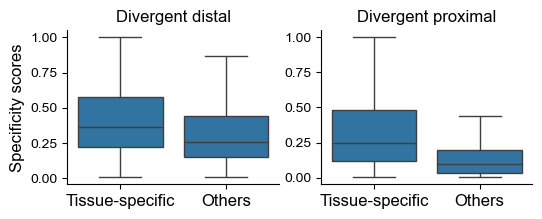

In [39]:
fig, ax = plt.subplots(1,2,figsize=(6,2))
for d in ds:
	col = ds.index(d)
	inputfile = f"{PROJECT_DIR_d}PROcap/processed/specificity_{p}_{d}.txt"
	df_scores = pd.read_table(inputfile, index_col=0)
	# Tissue-specific elements
	scores1 = list(df_scores.loc[list(es_specific[(p,d)])]["Specificity"])
	# Other elements
	scores2 = list(df_scores.loc[~df_scores.index.isin(es_specific[(p, d)])]["Specificity"])
	labels = ["Tissue-specific"] * len(scores1) + ["Others"] * len(scores2)
	g = sns.boxplot(x=labels, y=scores1+scores2, showfliers=False, ax=ax[col])
	g.spines[["top","right"]].set_visible(False)
	g.set_xlabel("")
	if col == 0:
		g.set_ylabel("Specificity scores", fontsize=bfontsize)
	else:
		g.set_ylabel("")
	g.tick_params(axis="x", labelsize=bfontsize)
	g.set_title(f"{p.capitalize()} {d}", fontsize=bfontsize)

In [42]:
# No. tissue-specific elements for each tissue

for d in ds:
	for t in tissues:
		df = pd.read_table(f"{outdir}/{p}_{d}_{t}.bed", index_col=0)
		print(p, d, len(df))
		break

divergent distal 7943
divergent proximal 2540


In [53]:
# Try different cutoffs for specificity scores to get a similar number of elements for non-tissue-specific group

cutoffs = {"distal": 0.1, "proximal": 0.02}
results = []
es_nonspecific = {}
for d in ds:
	inputfile = f"{PROJECT_DIR_d}PROcap/processed/specificity_{p}_{d}.txt"
	df_scores = pd.read_table(inputfile, index_col=0)
	df_nonspecific = df_scores.loc[~df_scores.index.isin(es_specific[(p, d)])]
	perc = stats.percentileofscore(list(df_scores["Specificity"]), cutoffs[d], kind='rank')
	es_nonspecific[d] = list(df_nonspecific[df_nonspecific["Specificity"]< cutoffs[d]].index)
	results.append([d, cutoffs[d], len(es_nonspecific[d]), perc])
pd.DataFrame(results, columns=["group", "cutoff", "No. elements", "percentile"])

,group,cutoff,No. elements,percentile
0,distal,0.10,7821,6.647260
1,proximal,0.02,2707,7.136801


In [52]:
# Non-tissue-specific elements

for d in ds:
	outputfile = f"{outdir}/{p}_{d}_Non_tissue_specific.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in es_nonspecific[d]:
			chrom, start, end = e.split("_")
			center = (int(end)+int(start))//2
			dw.write([chrom, center-extend, center+extend])

## Create an annot file

In [46]:
tissues2 = tissues + ["Non_tissue_specific"]

In [48]:
# gs://broad-alkesgroup-public-requester-pays/LDSCORE/GRCh38/plink_files.tgz

script = "/home/yc2553/slurm/LDSC/get_annotations.sh"
bim_prefix = f"{PROJECT_DIR_s}hg38/plink_files/1000G.EUR.hg38"

for d, t in itertools.product(ds, tissues2):
	bed_file = f"{outdir}/{p}_{d}_{t}.bed"
	annot_prefix = f"{outdir}/{p}_{d}_{t}"
	commands = " ".join(["sbatch", script,
						bed_file,
						bim_prefix,
						annot_prefix
						])
	print(commands)

sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Blood.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Blood
sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Lymph_node.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Lymph_node
sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Spleen.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2

In [47]:
# Check the output

inputfile = f"{outdir}/{p}_{d}_{t}.1.annot.gz"
df_annot = pd.read_table(inputfile)
df_annot.head(2)

,ANNOT
0,0
1,0


# Computing LD scores with an annot file

In [37]:
# gs://broad-alkesgroup-public-requester-pays/LDSCORE/w_hm3.snplist.bz2
# This SNP list matches with their baseline model

df = pd.read_table(f"{PROJECT_DIR_s}other_data/w_hm3.snplist")
df.head(2)

,SNP,A1,A2
0,rs3094315,G,A
1,rs3131972,A,G


In [38]:
# Need to remove the header; otherwise you'll get error message when running the codes below

df[["SNP"]].to_csv(f"{PROJECT_DIR_s}other_data/w_hm3_no_header.snplist", header=None, index=False, sep="\t")

In [49]:
script = "/home/yc2553/slurm/LDSC/get_LD_scores.sh"
bfile_prefix = f"{PROJECT_DIR_s}hg38/plink_files/1000G.EUR.hg38"
snps = f"{PROJECT_DIR_s}other_data/w_hm3_no_header.snplist"

for d, t in itertools.product(ds, tissues2):
	annot_prefix = f"{outdir}/{p}_{d}_{t}"
	commands = " ".join(["sbatch", script,
						bfile_prefix,
						annot_prefix,
						snps
						])
	print(commands)

sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Blood /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Lymph_node /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/0.05_1000/divergent_distal_Spleen /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553

In [50]:
# Check the output

inputfile = f"{outdir}/{p}_{d}_{t}.1.l2.ldscore.gz"
df_ldscore = pd.read_table(inputfile)
df_ldscore.head(2)

,CHR,SNP,BP,L2
0,1,rs3094315,817186,-0.002
1,1,rs3131972,817341,-0.004
